<center>
<img src="logo.png" height="900"> 
</center>


#  Береги уровень значимости с молоду 

В этой тетрадке мы будем работать с данными про Баскетбол. 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests
plt.style.use('ggplot')
%matplotlib inline

В файле `basketball.tsv` лежит [статистика о штрафных бросках в играх в Баскетбол, собранная с сайта ESPN.com](https://www.kaggle.com/sebastianmantey/nba-free-throws)

In [2]:
df = pd.read_csv('basketball.tsv', sep='\t')
print(df.shape)
df.head( )

(618019, 13)


,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,command,is_home
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,LAL,False
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,LAL,False
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26,LAL,False
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,LAL,False
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18,PHX,True


__Описание колонок:__

* `end_result` - результат игры
* `game` - какие команды играли, команда справа - хозяин площадки
* `game_id` - уникальный id игры
* `period` - период
* `player` - имя игрока
* `playoff` - тип игры
* `score` - счёт после броска 
* `season` - сезон игры
* `shot_made` - попал или не попал в кольцо при броске 
* `time` - время броска 
* `command` - предполагаемая команда игрока (колонка рассчитана по датасету)
* `is_home` - домашний матч или в гостях

# 1. Доля попаданий в корзину

Немного посмотрим на наши данные. Ответьте на следующие вопросы и запишите ответы в соотвествующие переменные. 

Сколько уникальных игр было сыграно в течение всего периода, который есть в таблице (`ans1`)? Сколько в данных встречается уникальных игроков (`ans2`)?

In [3]:
ans1 = df['game_id'].nunique()
ans2 = df['player'].nunique()

In [4]:
# проверка того, что задание решено верно
assert ans1 == 12874

# Другие подобные тесты скрыты от вас

Подсчитайте по каждому игроку статистику, связанную с тем, как часто он попадет в корзину при бросках:

- Долю попаданий в корзину среди его бросков, $\hat{p}$
- Число бросков, которое было сделано игроком, $n$

Среди игроков, которые сделали более ста бросков, найдите самого успешного. Запишите его в переменную `ans3`.

In [5]:
player_stats = df.groupby('player')['shot_made'].agg(['count', 'sum']).reset_index()
player_stats['p'] = player_stats['sum'] / player_stats['count']
player_stats = player_stats[(player_stats['count'] > 100)]
player_stats[player_stats['p'] == player_stats['p'].max()]['player'].values

array(['Steve Nash'], dtype=object)

In [6]:
ans3 = 'Steve Nash'

In [7]:
# проверка того, что задание решено верно
assert ans3.split(' ')[0][-1] == 'e'
assert len(ans3.split(' ')[0]) == 5

# Другие подобные тесты скрыты от вас

Для поиска `ans4` и `ans5` используйте данные по игрокам, сделавшим более ста бросков.  

Найдите медиану распределения доли попаданий, запишите её в переменную `ans4`. Найдите значение коэффициента асимметрии, запишите его в переменную `ans5`. Какое значение он принимает? Правда ли, что распределение этой переменной оказывается скошенным?

Постройте гистограмму для доли попаданий игроков, нарисуйте на ней пунктирной линией медиану. Проинтерпретируйте то, что вы видите на рисунке.  

In [8]:
player_stats.head()

,player,count,sum,p
0,A.J. Price,282,211,0.748227
1,Aaron Brooks,1109,928,0.836790
2,Aaron Gordon,254,173,0.681102
3,Aaron Gray,339,189,0.557522
6,Acie Law,229,179,0.781659


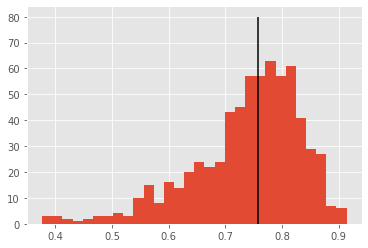

In [9]:
player_stats['p'].hist(bins=30)
plt.vlines(player_stats['p'].median(), 80, 0);

In [10]:
ans4 = player_stats['p'].median()
ans5 = sts.skew(player_stats['p'])

In [11]:
# проверка того, что задание решено верно
assert ans4 > 0.7
assert ans5 < -1

# Другие подобные тесты скрыты от вас

# 2. Игры дома и в гостях

Проанализируем, как часто игроки попадают в корзину дома и как часто в гостях. Подсчитайте доли попаданий в корзину в гостях и дома для всех ироков из выборки. Если для какого-то игрока оказывается, что он всегда играл только дома/только в гостях, удалите его из выборки.

Проверьте гипотезу о равенстве этих долей для каждого игрока против двусторонней альтернативы. Число гипотез, которые отклоняются на уровне значимости $5\%$,  запишите в переменную `ans6`. 

In [12]:
player_game = df.groupby(['player', 'is_home'])['shot_made'].agg(['count', 'sum']).reset_index()
player_game['p'] = player_game['sum'] / player_game['count']
player_game.head()

,player,is_home,count,sum,p
0,A.J. Price,False,150,115,0.766667
1,A.J. Price,True,132,96,0.727273
2,Aaron Brooks,False,572,474,0.828671
3,Aaron Brooks,True,537,454,0.845438
4,Aaron Gordon,False,134,92,0.686567


In [13]:
# Если для какого-то игрока оказывается, что он всегда играл только дома/только в гостях, удалите его из выборки.

In [14]:
del_player_game = player_game.groupby('player')[['is_home']].count().reset_index()
only_home_players = del_player_game[del_player_game['is_home'] == 1]['player'].values
only_home_players

array(['Aaron Harrison', 'Adonis Thomas', 'Alex Kirk', 'Alex Stepheson',
       'Alvin Williams', 'Andre Barrett', 'Andreas Glyniadakis',
       'Andy Rautins', 'Anfernee Hardaway', 'B.J. Mullens',
       'Billy Thomas', 'Branden Dawson', 'Carldell Johnson',
       'Cheick Samb', 'Cheikh Samb', 'Cj Watson', 'Craig Brackins',
       'D.J. Kennedy', 'D.J. Stephens', 'Dajuan Wagner',
       'Darius Johnson-Odom', 'Darryl Watkins', 'David Stockton',
       'Demetris Nichols', 'Dennis Horner', 'Derrick Byars',
       'Desmon Farmer', 'Doug Christie', 'Drew Gordon', 'Eddie Gill',
       'Eric Dawson', 'Eric Moreland', 'Fab Melo', 'Grant Jerrett',
       'Jamaal Franklin', 'James Augustine', 'James Lang',
       'James Nunnally', 'James Southerland', 'Jarell Eddie',
       'Jelani McCoy', 'Jerel McNeal', 'Joe Crawford', 'Julius Hodge',
       'Jumaine Jones', 'Justin Harper', 'Keith Appling', 'Kevin Willis',
       'Kosta Perovic', 'Lance Allred', 'Matt Freije', 'Pat Connaughton',
       'Pat

In [15]:
player_game = player_game[~player_game['player'].isin(only_home_players)].reset_index(drop=True)
player_game.head()

,player,is_home,count,sum,p
0,A.J. Price,False,150,115,0.766667
1,A.J. Price,True,132,96,0.727273
2,Aaron Brooks,False,572,474,0.828671
3,Aaron Brooks,True,537,454,0.845438
4,Aaron Gordon,False,134,92,0.686567


In [16]:
alpha = 0.05
ans6 = 0
player_game['pvalue'] = np.nan

for player in (player_game['player'].unique()):
    table = player_game[player_game['player'] == player].sort_values('is_home')[['count', 'sum']]
    pvalue = proportions_ztest((table['sum'].values), (table['count'].values), value=0)[1]
   
    player_game.loc[player_game['player'] == player, 'pvalue'] = pvalue
    
    if pvalue < alpha:
        ans6 += 1

C:\Users\Alexey93\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff
C:\Users\Alexey93\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2007: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [17]:
# проверка того, что задание решено верно
assert ans6 < 100
assert ans6 > 60

# другие подобные тесты скрыты от вас

Введите коррекцию с помощью метода Холма. Запишите число гипотез, которые были отклонены на уровне значимости $5\%$, в переменную `ans7`.

In [18]:
pval = player_game['pvalue'].drop_duplicates().dropna()

rejected, p_corrected, _, _ = multipletests(pval, 
                                            alpha = alpha, 
                                            method = 'holm')
ans7 = sum(rejected)

Введите коррекцию с помощью метода Бенжамини-Хохберга. Запишите число гипотез, которые были отклонены на уровне значимости $5\%$, в переменную `ans8`.

In [19]:
rejected, p_corrected, _, _ = multipletests(pval, 
                                            alpha = alpha, 
                                            method = 'fdr_bh')

ans8 = sum(rejected)

In [20]:
# проверка того, что задание решено верно
assert ans7 < 10
assert ans8 < 10

# другие подобные тесты скрыты от вас

Объясните разницу, которую вы получили в количестве отклоненных гипотез. Предположим, что вы менеджер команды и вы хотите на основе статистики принять решение о том, какие игроки должны играть на поле в домашнем матче. Как вы будете его принимать? 

Отсортируйте таблицу по `pvalue`, полученному из самого первого теста. Посмотрите на самые большие и самые маленькие значения. Какое число наблюдений им соотвествуте? Как думаете, почему гипотезы для маленького числа наблюдений не отвергаются? Как это связано с ЗБЧ? Можно ли доверять этим результатам? Как их можно было бы решить при предобработке данных? 

In [21]:
player_game.sort_values('pvalue', ascending=False).dropna()

,player,is_home,count,sum,p,pvalue
1406,Mickell Gladness,False,4,2,0.500000,1.00000
378,Cristiano Felicio,False,14,10,0.714286,1.00000
1323,Marcus Vinicius,True,9,5,0.555556,1.00000
1350,Marshon Brooks,False,12,10,0.833333,1.00000
1351,Marshon Brooks,True,6,5,0.833333,1.00000
...,...,...,...,...,...,...
827,Jamario Moon,True,101,70,0.693069,0.00070
91,Andrew Bogut,True,612,300,0.490196,0.00066
90,Andrew Bogut,False,718,419,0.583565,0.00066
811,Jahlil Okafor,True,105,83,0.790476,0.00063


# 3. Постоянство - признак мастерства

__Решение задач из этого пункта является не обязательным и никак не влияет на вашу оценку.__ 

В наших данных есть несколько сезонов. Постройте гистограмму с распределением числа игр по каждому году. Видна ли на гистограмме [аномалия, произошедшая в $2011$ году?](https://en.wikipedia.org/wiki/2011_NBA_lockout) 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here

- Посчитайте для каждого игрока по каждому сезону долю попаданий в кольцо и количество сделанных бросков. 
- Оставьте в данных только те строки, где было сделано как минимум сто бросков. Удалите колонку с количеством сделанных бросков. 
- Методом `unstack("player")` вытащите индексы, отвечающие в группировке за игроков в названия столбцов. Методом `droplevel()` удалите все лишние заголовки таблицы.
- Удалите из данных всех игроков, у которых пропущена статистика хотя бы по одному сезону.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

shooting_per_season = ...

# your code here


In [ ]:
assert shooting_per_season.shape == (10, 27)

Посчтитайте для всех игроков стандартное отклонение их доли попаданий в динамике по сезонам. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here


Постройте для $3$ самых непредсказуемых игроков и для трёх самых предсказуемых игроков динамику доли их попаданий по сезонам (по оси $x$ сезоны, по оси $y$ доля попаданий). 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here


Каких игроков из представленных вы бы предпочли взять к себе в команду? Кому бы вы предпочли доверить делать штрафные броски? Почему? 

# 4. Эффект победителя

__Решение задач из этого пункта является не обязательным и никак не влияет на вашу оценку.__ 

__Гипотеза:__

> Если мы попали в корзину, сделав первый штрафной бросок, вероятность попасть при втором штрафном выше, чем если бы мы промахнулись.

Проверим эту гипотезу. 

- Создадим в исходной таблице колонку `shot_made_previous` методом `shift()`. В ней будет записан результат предыдущего броска. Данные отсортированы по времени.
- Извлечём из данных в таблицу `winner_effect` все строки, где в колонке `play` находится одна из записей: `"2 of 2", "2 of 3", "3 of 3"`. Каждая из них означает, что предыдущий бросок был сделан успешно. Этот же срез выбросит из таблицы все строки, где сдвиг, сделанный в предыдущем пункте, привёл к появлению некорректных записей.  

In [ ]:
df["shot_made_previous"] = df.shot_made.shift()

winner_effect = df[(df.play.str.contains("2 of 2")) | \
                   (df.play.str.contains("2 of 3")) | 
                   (df.play.str.contains("3 of 3"))]

По аналогии с пунктом $2$ найдите вероятность попасть в корзину при условии, что первый бросок был успешен, и вероятность попасть, при условии, что первый бросок был неуспешен. 

- Всех игроков с оценкой только одной из вероятностей удалите из данных.
- Всех игроков, у которых было меньше $10$ успешных первых бросков либо проваленных первых бросков, также удалите.

Для каждого игрока проверьте гипотезу о том, что эти две вероятности совпадают. Используйте уровень значимости $5\%$. Для коррекции уровня значимости используйте методы Холма и Бенжамини-Хохберга. Для скольких игроков гипотеза об эффекте победителя не отвергается?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here


Посмотрите на таблицу значимых по Бенжамини-Хохбергу эффектов. Какие из них на ваш взгляд являются существенными? Не допустили ли мы в этих ситуациях ошибку второго рода?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here


В свободное время посмотрите фильм ["Человек, который изменил всё"](https://www.kinopoisk.ru/film/432791/) про спортивных скаутов. В нём играет молодой Брэд Пит, а ещё он про статистику.

<center>
<img src="https://img3.goodfon.ru/original/2026x1236/1/68/moneyball-bratt-pitt-actor.jpg" width="700"> 
</center>
